**deepSISOnoCSI**<br>
by $\text{Rishabh Pomaje}$
- Autoencoder based SISO system with no **CSI** 
- Objectives : 
    - To learn a (4, 7) system under the following conditions :
        1. Flat-fading, Fast-fading  
        2. Rayleigh Channel with AWGN 
        3. Channel Model : $y_i = h_i x_i + w_i$
            - where, $h \overset{i.i.d}{\sim} \mathcal{CN}(0, 1)$ and $w \overset{i.i.d}{\sim} \mathcal{CN}(0, N_0)$

**Definitions**
\begin{equation}
    \text{SNR}_{linear} = \text{Signal-to-noise power ratio per symbol time} = \frac{E_b}{2N_0}
\end{equation}
Consider,
\begin{equation*}
    \frac{1}{2 \times SNR_{linear}} = \frac{1 \times 2N_0}{2 \times E_b} = \frac{N_0}{a} = N_0 \;\dots (a = 1) 
\end{equation*}

In [51]:
# Importing the dependencies 
import tensorflow as tf
import numpy as np 
import matplotlib.pyplot as plt 
%config InlineBackend.figure_format='svg' # Comment this for faster plot rendering 
print(tf.__version__)

2.16.1


### Without Coding

- System Parameters/ Definitions 

In [52]:
M = 2                       # Size of alphabet
k = 1                       # Number of bits required
n = 2                       # Size of coded vector 
R = k / n                   # Information/ Communication rate 

- Generation of training data

In [53]:
training_set_size = 10 ** 6 # Equivalent to k million bits

# Random indices 
sample_indices = np.random.randint(0, M, training_set_size)

# Random 1-hot vectors
x_train = np.zeros((training_set_size, M))
x_train[np.arange(training_set_size), sample_indices] = 1  # One-hot encoding
print(f'One Hot encoded vectors :{x_train}')
print(f'Input Shape :{np.shape(x_train)}')
# Since we are reproducing the input at the output :
y_train = x_train # Setting the labels as the inputs 

# Generate random fading tap samples for training
fading_mean = 0 
fading_std = np.sqrt(0.5)
fading_taps_I = np.random.normal(fading_mean, fading_std, (training_set_size, n)) 
fading_taps_Q = np.random.normal(fading_mean, fading_std, (training_set_size, n))

One Hot encoded vectors :[[1. 0.]
 [0. 1.]
 [1. 0.]
 ...
 [0. 1.]
 [0. 1.]
 [1. 0.]]
Input Shape :(1000000, 2)


- Creating the Autoencoder

In [54]:
# Description of the encoder(transmitter) part :
enc_input_layer = tf.keras.Input(shape=(M,), name="Input Layer")
enc_layer_01 = tf.keras.layers.Dense(M, activation='relu', name="Encoder_Hidden_01")(enc_input_layer)
enc_layer_02 = tf.keras.layers.Dense(n, activation='linear', name="Encoder_Hidden_02")(enc_layer_01)
enc_layer_normalized = tf.keras.layers.Lambda((lambda x: np.sqrt(n / 2) * tf.keras.backend.l2_normalize(x, axis=-1)), name='Power_Constraint')(enc_layer_02)

# Describing the AWGN Channel with Rayleigh fading :
fading_layer_real = tf.keras.Input(shape=(n, ), name='fading_real_part')
fading_layer_imag = tf.keras.Input(shape=(n,), name='fading_taps_imag')
# y = fx + w  model(flat + fast fading):
rx_signal_real = tf.keras.layers.Multiply()([enc_layer_normalized, fading_layer_real])
rx_signal_imag = tf.keras.layers.Multiply()([enc_layer_normalized, fading_layer_imag])

# Adding the Gaussian noise :
SNR_dB = 10
SNR_lin = 10 ** (SNR_dB / 10)
rx_noisy_signal_real = tf.keras.layers.GaussianNoise(stddev=np.sqrt(1 / (4 * SNR_lin)), name='AWGN_channel_I')(rx_signal_real)
rx_noisy_signal_imag = tf.keras.layers.GaussianNoise(stddev=np.sqrt(1 / (4 * SNR_lin)), name='AWGN_channel_Q')(rx_signal_imag)

# Description of the decoder part :
# Concatenating the real and imag noisy signal at the decoder part :
rx_signal = tf.keras.layers.Concatenate()([rx_noisy_signal_real, rx_noisy_signal_imag])
dec_layer_01 = tf.keras.layers.Dense(8*M, activation='relu', name='Decoder_Hidden_01')(rx_signal)
dec_layer_02 = tf.keras.layers.Dense(4*M, activation='relu', name='Decoder_Hidden_02')(dec_layer_01)
dec_layer_03 = tf.keras.layers.Dense(2*M, activation='relu', name='Decoder_Hidden_03')(dec_layer_02)
dec_layer_04 = tf.keras.layers.Dense(M, activation='relu', name='Decoder_Hidden_04')(dec_layer_03)
dec_output_layer = tf.keras.layers.Dense(M, activation='softmax', name='Output_Layer')(dec_layer_04)

autoencoder = tf.keras.Model(
                    inputs = [enc_input_layer, fading_layer_real, fading_layer_imag], 
                    outputs = [dec_output_layer],
                )

# Compiling the model :
autoencoder.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=0.001), loss=tf.keras.losses.CategoricalCrossentropy(), metrics=['accuracy'])
autoencoder.summary()


Model: "functional_43"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ Input Layer         │ (None, 2)         │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ Encoder_Hidden_01   │ (None, 2)         │          6 │ Input Layer[0][0] │
│ (Dense)             │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ Encoder_Hidden_02   │ (None, 2)         │          6 │ Encoder_Hidden_0… │
│ (Dense)             │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ Power_Constraint    │ (None, 2)         │          0 │ Encoder_Hidden_0… │
│ (Lambda)            │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ fading_real_part    │ (None, 2)         │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ fading_taps_imag    │ (None, 2)         │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ multiply_38         │ (None, 2)         │          0 │ Power_Constraint… │
│ (Multiply)          │                   │            │ fading_real_part… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ multiply_39         │ (None, 2)         │          0 │ Power_Constraint… │
│ (Multiply)          │                   │            │ fading_taps_imag… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ AWGN_channel_I      │ (None, 2)         │          0 │ multiply_38[0][0] │
│ (GaussianNoise)     │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ AWGN_channel_Q      │ (None, 2)         │          0 │ multiply_39[0][0] │
│ (GaussianNoise)     │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ concatenate_19      │ (None, 4)         │          0 │ AWGN_channel_I[0… │
│ (Concatenate)       │                   │            │ AWGN_channel_Q[0… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ Decoder_Hidden_01   │ (None, 16)        │         80 │ concatenate_19[0… │
│ (Dense)             │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ Decoder_Hidden_02   │ (None, 8)         │        136 │ Decoder_Hidden_0… │
│ (Dense)             │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ Decoder_Hidden_03   │ (None, 4)         │         36 │ Decoder_Hidden_0… │
│ (Dense)             │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ Decoder_Hidden_04   │ (None, 2)         │         10 │ Decoder_Hidden_0… │
│ (Dense)             │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ Output_Layer        │ (None, 2)         │          6 │ Decoder_Hidden_0… │
│ (Dense)             │                   │            │                   │
└─────────────────────┴───────────────────┴────────────┴───────────────────┘

 Total params: 280 (1.09 KB)

 Trainable params: 280 (1.09 KB)

 Non-trainable params: 0 (0.00 B)

In [ ]:
tf.keras.utils.plot_model(
    autoencoder,
    to_file='images/deepSISOnoCSI.png',
    show_shapes=True,
    show_dtype=True,
    show_layer_names=True,
    rankdir='TB',
    expand_nested=True,
    dpi=200,
    show_layer_activations=True,
    show_trainable=True,
)

- Training the autoencoder

In [55]:
autoencoder.fit([x_train, fading_taps_I, fading_taps_Q], y_train, batch_size=1000, epochs=100)

Epoch 1/100
1000/1000 ━━━━━━━━━━━━━━━━━━━━ 4s 2ms/step - accuracy: 0.7908 - loss: 0.3630
Epoch 2/100
1000/1000 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step - accuracy: 0.9537 - loss: 0.1025
Epoch 3/100
1000/1000 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step - accuracy: 0.9537 - loss: 0.1016
Epoch 4/100
1000/1000 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step - accuracy: 0.9540 - loss: 0.1001
Epoch 5/100
1000/1000 ━━━━━━━━━━━━━━━━━━━━ 3s 3ms/step - accuracy: 0.9535 - loss: 0.1011
Epoch 6/100
1000/1000 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step - accuracy: 0.9538 - loss: 0.1001
Epoch 7/100
1000/1000 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step - accuracy: 0.9535 - loss: 0.1005
Epoch 8/100
1000/1000 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step - accuracy: 0.9533 - loss: 0.1001
Epoch 9/100
1000/1000 ━━━━━━━━━━━━━━━━━━━━ 3s 2ms/step - accuracy: 0.9542 - loss: 0.0996
Epoch 10/100
1000/1000 ━━━━━━━━━━━━━━━━━━━━ 3s 2ms/step - accuracy: 0.9543 - loss: 0.0987
Epoch 11/100
1000/1000 ━━━━━━━━━━━━━━━━━━━━ 3s 3ms/step - accuracy: 0.9546 - loss: 0.0989
Epoch 12/100
1000/1

- Testing the above encoder at various SNRs

Generation of testing/ validation data 

In [56]:
testing_set_size = 10 ** 6
y_test = np.random.randint(0, M, testing_set_size)
x_test = np.zeros((testing_set_size, M))  
x_test[np.arange(testing_set_size), y_test] = 1  # One-hot encoding
print(x_test)

[[0. 1.]
 [1. 0.]
 [1. 0.]
 ...
 [0. 1.]
 [0. 1.]
 [0. 1.]]


- Abstracting the encoder and decoder for use from the trained autoencoder

In [57]:
# Abstracting out the encoder model :
encoder_model = tf.keras.Model(enc_input_layer, enc_layer_normalized)

# Codeword Received at the receiver :
rx_noisy_signal_I = tf.keras.Input(shape=(n,))
rx_noisy_signal_Q = tf.keras.Input(shape=(n,))
decoder_output = autoencoder.layers[-6]([rx_noisy_signal_I, rx_noisy_signal_Q])
decoder_output = autoencoder.layers[-5](decoder_output)
decoder_output = autoencoder.layers[-4](decoder_output)
decoder_output = autoencoder.layers[-3](decoder_output)
decoder_output = autoencoder.layers[-2](decoder_output)
decoder_output = autoencoder.layers[-1](decoder_output)

# Abstracting out the decoder model :
decoder_model = tf.keras.Model([rx_noisy_signal_I, rx_noisy_signal_Q], decoder_output)

- Validation Routine

In [58]:
# Range of Signal to Noise Ratio :
# in dB :
SNR_dB = np.linspace(-2, 20, 30)
# in Linear Scale :
SNR_lin = 10 ** (SNR_dB / 10)
# Fixing energy per bit :
E_b = 1 
# Range of total noise variance accordingly :
noise_var = 1 / (2 * SNR_lin) 
print(encoder_model.predict(x_test))

31250/31250 ━━━━━━━━━━━━━━━━━━━━ 23s 741us/step
[[-0.99999815 -0.00192919]
 [-0.00175948 -0.99999845]
 [-0.00175948 -0.99999845]
 ...
 [-0.99999815 -0.00192919]
 [-0.99999815 -0.00192919]
 [-0.99999815 -0.00192919]]


- We are restraining to using only BPSK mapping
We define SNR as follows :
\begin{equation}
\text{SNR}_{linear} = \frac{\text{Received signal energy per bit}}{\text{Noise Spectral density}}
\end{equation}
- Per bit energies :
- BPSK : {$\pm \sqrt{E_{b}}$}
- $E_{uncoded} = 1 $
\begin{equation}
E_{coded} = E_{uncoded} \times k / n = E_{uncoded} \times R
\end{equation}
- $R$ = Information Rate 
- $\color{red}{Note}$ : This difference in energy per bit needs to be compensated in either symbol energy or the noise variance. I have arbitrarily chosen it to be the noise variance.

In [59]:
BLER_learned_uncoded = []
for noise in noise_var:
    # Encoding
    encoded_signal = encoder_model.predict(x_test)
    # Fading 
    fade_taps = np.random.normal(fading_mean, fading_std, (testing_set_size, n)) + 1j * np.random.normal(fading_mean, fading_std, (testing_set_size, n))
    faded_signal = fade_taps * encoded_signal
    # Noise
    noise_samples = np.random.normal(0, np.sqrt(noise/2), (testing_set_size, n)) + 1j * np.random.normal(0, np.sqrt(noise/2), (testing_set_size, n))
    noisy_signal = faded_signal + noise_samples
    # Decoding
    decoded_signal = decoder_model.predict([np.real(noisy_signal), np.imag(noisy_signal)])
    # Analysis
    estimated_vectors = np.argmax(decoded_signal, axis=-1)
    BLER_learned_uncoded.append(np.sum(estimated_vectors != y_test) / testing_set_size)

31250/31250 ━━━━━━━━━━━━━━━━━━━━ 25s 804us/step
31250/31250 ━━━━━━━━━━━━━━━━━━━━ 37s 1ms/step
31250/31250 ━━━━━━━━━━━━━━━━━━━━ 23s 749us/step
31250/31250 ━━━━━━━━━━━━━━━━━━━━ 70s 2ms/step
31250/31250 ━━━━━━━━━━━━━━━━━━━━ 60s 2ms/step
31250/31250 ━━━━━━━━━━━━━━━━━━━━ 93s 3ms/step
31250/31250 ━━━━━━━━━━━━━━━━━━━━ 60s 2ms/step
31250/31250 ━━━━━━━━━━━━━━━━━━━━ 94s 3ms/step
31250/31250 ━━━━━━━━━━━━━━━━━━━━ 59s 2ms/step
31250/31250 ━━━━━━━━━━━━━━━━━━━━ 95s 3ms/step
31250/31250 ━━━━━━━━━━━━━━━━━━━━ 59s 2ms/step
31250/31250 ━━━━━━━━━━━━━━━━━━━━ 95s 3ms/step
31250/31250 ━━━━━━━━━━━━━━━━━━━━ 61s 2ms/step
31250/31250 ━━━━━━━━━━━━━━━━━━━━ 94s 3ms/step
31250/31250 ━━━━━━━━━━━━━━━━━━━━ 59s 2ms/step
31250/31250 ━━━━━━━━━━━━━━━━━━━━ 94s 3ms/step
31250/31250 ━━━━━━━━━━━━━━━━━━━━ 59s 2ms/step
31250/31250 ━━━━━━━━━━━━━━━━━━━━ 102s 3ms/step
31250/31250 ━━━━━━━━━━━━━━━━━━━━ 59s 2ms/step
31250/31250 ━━━━━━━━━━━━━━━━━━━━ 94s 3ms/step
31250/31250 ━━━━━━━━━━━━━━━━━━━━ 59s 2ms/step
31250/31250 ━━━━━━━━━━━━━━━━━

In [60]:
np.sum(np.linalg.norm(encoded_signal) ** 2)

1000000.0

In [77]:
print(f'BLER_learned_uncoded = {BLER_learned_uncoded}')

BLER_learned_uncoded = [0.309743, 0.289982, 0.266457, 0.244382, 0.222372, 0.201309, 0.180745, 0.159852, 0.14164, 0.1248, 0.109083, 0.094811, 0.081599, 0.070974, 0.060838, 0.051783, 0.044245, 0.037794, 0.032131, 0.027354, 0.022841, 0.019713, 0.016655, 0.014115, 0.012017, 0.010271, 0.008683, 0.00737, 0.006175, 0.005352]


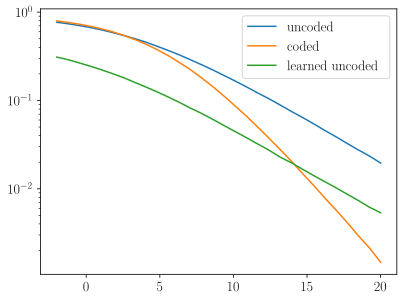

In [75]:
BLER_uncoded_ortho = [0.768583, 0.739292, 0.705981, 0.669923, 0.630311, 0.587876, 0.544343, 0.500471, 0.455975, 0.410657, 0.367179, 0.327169, 0.287849, 0.252541, 0.220754, 0.191105, 0.165363, 0.142107, 0.121575, 0.104422, 0.08893, 0.075213, 0.064247, 0.054353, 0.045771, 0.038804, 0.032647, 0.027541, 0.023478, 0.019544]
BLER_coded_ortho_hard = [0.795571, 0.765834, 0.731717, 0.692848, 0.648438, 0.599435, 0.545317, 0.489533, 0.432764, 0.375165, 0.320971, 0.267871, 0.221556, 0.178709, 0.142342, 0.111386, 0.086019, 0.066173, 0.049922, 0.037385, 0.027819, 0.020596, 0.014932, 0.010915, 0.007867, 0.005756, 0.004155, 0.00294, 0.002141, 0.001472]

plt.semilogy(SNR_dB, BLER_uncoded_ortho, label='uncoded')
plt.semilogy(SNR_dB, BLER_coded_ortho_hard, label='coded')
plt.semilogy(SNR_dB, BLER_learned_uncoded, label="learned uncoded")
plt.legend()

### With Coding 

- System Parameters/ Definitions 

In [63]:
k = 4                       # Number of bits required
n = 7                       # Size of coded vector 
M = 2 ** k                  # Size of alphabet
R = k / n                   # Information/ Communication rate 

- Generation of training data

In [64]:
training_set_size = 10 ** 6 # Equivalent to k million bits

# Random indices 
sample_indices = np.random.randint(0, M, training_set_size)

# Random 1-hot encoded vectors
x_train = np.zeros((training_set_size, M))
x_train[np.arange(training_set_size), sample_indices] = 1  # One-hot encoding
print(f'One Hot encoded vectors :{x_train}')
print(f'Input Shape :{np.shape(x_train)}')
# Since we are reproducing the input at the output :
y_train = x_train # Setting the labels as the inputs 

# Generate random fading tap samples for training
fading_mean = 0 
fading_std = np.sqrt(0.5)
# # Rayleigh Fading :
fading_taps_I = np.random.normal(fading_mean, fading_std, (training_set_size, n)) 
fading_taps_Q = np.random.normal(fading_mean, fading_std, (training_set_size, n))

One Hot encoded vectors :[[1. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 ...
 [0. 0. 1. ... 0. 0. 0.]
 [0. 0. 0. ... 1. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]]
Input Shape :(1000000, 16)


- Creating the Autoencoder

In [85]:
# Description of the encoder(transmitter) part :
enc_input_layer = tf.keras.Input(shape=(M,), name="Input Layer")
enc_layer_01 = tf.keras.layers.Dense(M, activation='relu', name="Encoder_Hidden_01")(enc_input_layer)
enc_layer_02 = tf.keras.layers.Dense(n, activation='linear', name="Encoder_Hidden_02")(enc_layer_01)
enc_layer_normalized = tf.keras.layers.Lambda((lambda x: np.sqrt(n) * tf.keras.backend.l2_normalize(x, axis=-1)), name='Power_Constraint')(enc_layer_02)

# Describing the AWGN Channel with Rayleigh fading :
fading_layer_real = tf.keras.Input(shape=(n, ), name='fading_real_part')
fading_layer_imag = tf.keras.Input(shape=(n, ), name='fading_taps_imag')
# y = fx + w  model(flat + fast fading):
rx_signal_real = tf.keras.layers.Multiply()([enc_layer_normalized, fading_layer_real])
rx_signal_imag = tf.keras.layers.Multiply()([enc_layer_normalized, fading_layer_imag])

# Adding the Gaussian noise :
SNR_dB = 10
SNR_lin = 10 ** (SNR_dB / 10)
rx_noisy_signal_real = tf.keras.layers.GaussianNoise(stddev=np.sqrt(1 / (4 * R * SNR_lin)), name='AWGN_channel_I')(rx_signal_real)
rx_noisy_signal_imag = tf.keras.layers.GaussianNoise(stddev=np.sqrt(1 / (4 * R * SNR_lin)), name='AWGN_channel_Q')(rx_signal_imag)

# Description of the decoder part :
# Concatenating the real and imag noisy signal at the decoder part :
rx_signal = tf.keras.layers.Concatenate()([rx_noisy_signal_real, rx_noisy_signal_imag])
dec_layer_01 = tf.keras.layers.Dense(8*n, activation='relu', name='Decoder_Hidden_01')(rx_signal)
dec_layer_02 = tf.keras.layers.Dense(4*M, activation='relu', name='Decoder_Hidden_02')(dec_layer_01)
dec_layer_03 = tf.keras.layers.Dense(M, activation='relu', name='Decoder_Hidden_03')(dec_layer_02)
dec_output_layer = tf.keras.layers.Dense(M, activation='softmax', name='Output_Layer')(dec_layer_03)

autoencoder = tf.keras.Model(
                    inputs = [enc_input_layer, fading_layer_real, fading_layer_imag], 
                    outputs = [dec_output_layer],
                )

# Compiling the model :
autoencoder.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=0.001), loss=tf.keras.losses.CategoricalCrossentropy(), metrics=['accuracy'])
autoencoder.summary()

Model: "functional_57"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ Input Layer         │ (None, 16)        │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ Encoder_Hidden_01   │ (None, 16)        │        272 │ Input Layer[0][0] │
│ (Dense)             │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ Encoder_Hidden_02   │ (None, 7)         │        119 │ Encoder_Hidden_0… │
│ (Dense)             │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ Power_Constraint    │ (None, 7)         │          0 │ Encoder_Hidden_0… │
│ (Lambda)            │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ fading_real_part    │ (None, 7)         │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ fading_taps_imag    │ (None, 7)         │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ multiply_44         │ (None, 7)         │          0 │ Power_Constraint… │
│ (Multiply)          │                   │            │ fading_real_part… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ multiply_45         │ (None, 7)         │          0 │ Power_Constraint… │
│ (Multiply)          │                   │            │ fading_taps_imag… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ AWGN_channel_I      │ (None, 7)         │          0 │ multiply_44[0][0] │
│ (GaussianNoise)     │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ AWGN_channel_Q      │ (None, 7)         │          0 │ multiply_45[0][0] │
│ (GaussianNoise)     │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ concatenate_22      │ (None, 14)        │          0 │ AWGN_channel_I[0… │
│ (Concatenate)       │                   │            │ AWGN_channel_Q[0… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ Decoder_Hidden_01   │ (None, 56)        │        840 │ concatenate_22[0… │
│ (Dense)             │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ Decoder_Hidden_02   │ (None, 64)        │      3,648 │ Decoder_Hidden_0… │
│ (Dense)             │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ Decoder_Hidden_03   │ (None, 16)        │      1,040 │ Decoder_Hidden_0… │
│ (Dense)             │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ Output_Layer        │ (None, 16)        │        272 │ Decoder_Hidden_0… │
│ (Dense)             │                   │            │                   │
└─────────────────────┴───────────────────┴────────────┴───────────────────┘

 Total params: 6,191 (24.18 KB)

 Trainable params: 6,191 (24.18 KB)

 Non-trainable params: 0 (0.00 B)

- Training the autoencoder

In [86]:
autoencoder.fit([x_train, fading_taps_I, fading_taps_Q], y_train, batch_size=1000, epochs=100)

Epoch 1/100
1000/1000 ━━━━━━━━━━━━━━━━━━━━ 4s 3ms/step - accuracy: 0.4750 - loss: 1.4908
Epoch 2/100
1000/1000 ━━━━━━━━━━━━━━━━━━━━ 3s 3ms/step - accuracy: 0.8240 - loss: 0.4476
Epoch 3/100
1000/1000 ━━━━━━━━━━━━━━━━━━━━ 3s 3ms/step - accuracy: 0.8443 - loss: 0.3961
Epoch 4/100
1000/1000 ━━━━━━━━━━━━━━━━━━━━ 3s 3ms/step - accuracy: 0.9014 - loss: 0.3014
Epoch 5/100
1000/1000 ━━━━━━━━━━━━━━━━━━━━ 3s 3ms/step - accuracy: 0.9061 - loss: 0.2858
Epoch 6/100
1000/1000 ━━━━━━━━━━━━━━━━━━━━ 3s 3ms/step - accuracy: 0.9081 - loss: 0.2784
Epoch 7/100
1000/1000 ━━━━━━━━━━━━━━━━━━━━ 3s 3ms/step - accuracy: 0.9091 - loss: 0.2745
Epoch 8/100
1000/1000 ━━━━━━━━━━━━━━━━━━━━ 3s 3ms/step - accuracy: 0.9095 - loss: 0.2729
Epoch 9/100
1000/1000 ━━━━━━━━━━━━━━━━━━━━ 3s 3ms/step - accuracy: 0.9098 - loss: 0.2720
Epoch 10/100
1000/1000 ━━━━━━━━━━━━━━━━━━━━ 3s 3ms/step - accuracy: 0.9098 - loss: 0.2714
Epoch 11/100
1000/1000 ━━━━━━━━━━━━━━━━━━━━ 3s 3ms/step - accuracy: 0.9102 - loss: 0.2708
Epoch 12/100
1000/1

- Testing the above encoder at various SNRs

Generation of testing/ validation data 

In [87]:
testing_set_size = 10 ** 6
y_test = np.random.randint(0, M, testing_set_size)
x_test = np.zeros((testing_set_size, M))  
x_test[np.arange(testing_set_size), y_test] = 1  # One-hot encoding
print(x_test)

[[0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 1. 0. 0.]
 ...
 [0. 0. 0. ... 0. 0. 1.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 1.]]


- Abstracting the encoder and decoder for use from the trained autoencoder

In [88]:
# Abstracting out the encoder model :
encoder_model = tf.keras.Model(enc_input_layer, enc_layer_normalized)

# Codeword Received at the receiver :
rx_noisy_signal_I = tf.keras.Input(shape=(n,))
rx_noisy_signal_Q = tf.keras.Input(shape=(n,))
decoder_output = autoencoder.layers[-5]([rx_noisy_signal_I, rx_noisy_signal_Q])
decoder_output = autoencoder.layers[-4](decoder_output)
decoder_output = autoencoder.layers[-3](decoder_output)
decoder_output = autoencoder.layers[-2](decoder_output)
decoder_output = autoencoder.layers[-1](decoder_output)

# Abstracting out the decoder model :
decoder_model = tf.keras.Model([rx_noisy_signal_I, rx_noisy_signal_Q], decoder_output)

- Validation Routine

In [89]:
# Range of Signal to Noise Ratio :
# in dB :
SNR_dB = np.linspace(-2, 20, 30)
# in Linear Scale :
SNR_lin = 10 ** (SNR_dB / 10)
# Fixing energy per bit :
E_b = 1 
# Range of total noise variance accordingly :
noise_var = 1 / (2 * R * SNR_lin) 
print(encoder_model.predict(x_test[:5]))

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 56ms/step
[[-1.82065785e+00  1.91956544e+00  1.51617937e-02  2.22154125e-03
  -1.35194277e-02  5.06910682e-03 -5.53108426e-03]
 [-4.68564406e-03  1.34158838e+00 -9.44535714e-03  1.78113770e+00
  -3.96389188e-03 -1.30148735e-02 -1.42386532e+00]
 [ 1.82047337e-02  1.29646389e-02 -1.68658936e+00 -1.41858775e-02
   1.59621406e+00  1.26759970e+00  2.66833138e-03]
 [ 2.64563727e+00  1.78742204e-02 -1.12593658e-02 -7.93486275e-03
   3.26501904e-03  7.10576074e-03 -5.71007933e-03]
 [ 1.43133001e-02  2.64550495e+00 -9.59989149e-03 -1.50108989e-03
  -2.72562280e-02 -5.90397138e-03  1.50272232e-02]]


In [90]:
BLER_learned_coded = []
for noise in noise_var:
    # Encoding
    encoded_signal = encoder_model.predict(x_test)
    # Fading 
    fade_taps = np.random.normal(fading_mean, fading_std, (testing_set_size, n)) + 1j * np.random.normal(fading_mean, fading_std, (testing_set_size, n))
    faded_signal = fade_taps * encoded_signal
    # Noise
    noise_samples = np.random.normal(0, np.sqrt(noise/2), (testing_set_size, n)) + 1j * np.random.normal(0, np.sqrt(noise/2), (testing_set_size, n))
    noisy_signal = faded_signal + noise_samples
    # Decoding
    decoded_signal = decoder_model.predict([np.real(noisy_signal), np.imag(noisy_signal)])
    # Analysis
    estimated_vectors = np.argmax(decoded_signal, axis=-1)
    BLER_learned_coded.append(np.sum(estimated_vectors != y_test) / testing_set_size)

31250/31250 ━━━━━━━━━━━━━━━━━━━━ 24s 773us/step
31250/31250 ━━━━━━━━━━━━━━━━━━━━ 36s 1ms/step
31250/31250 ━━━━━━━━━━━━━━━━━━━━ 24s 755us/step
31250/31250 ━━━━━━━━━━━━━━━━━━━━ 87s 3ms/step
31250/31250 ━━━━━━━━━━━━━━━━━━━━ 53s 2ms/step
31250/31250 ━━━━━━━━━━━━━━━━━━━━ 78s 2ms/step
31250/31250 ━━━━━━━━━━━━━━━━━━━━ 57s 2ms/step
31250/31250 ━━━━━━━━━━━━━━━━━━━━ 95s 3ms/step
31250/31250 ━━━━━━━━━━━━━━━━━━━━ 57s 2ms/step
31250/31250 ━━━━━━━━━━━━━━━━━━━━ 97s 3ms/step
31250/31250 ━━━━━━━━━━━━━━━━━━━━ 58s 2ms/step
31250/31250 ━━━━━━━━━━━━━━━━━━━━ 99s 3ms/step
31250/31250 ━━━━━━━━━━━━━━━━━━━━ 55s 2ms/step
31250/31250 ━━━━━━━━━━━━━━━━━━━━ 96s 3ms/step
31250/31250 ━━━━━━━━━━━━━━━━━━━━ 54s 2ms/step
31250/31250 ━━━━━━━━━━━━━━━━━━━━ 88s 3ms/step
31250/31250 ━━━━━━━━━━━━━━━━━━━━ 56s 2ms/step
31250/31250 ━━━━━━━━━━━━━━━━━━━━ 83s 3ms/step
31250/31250 ━━━━━━━━━━━━━━━━━━━━ 61s 2ms/step
31250/31250 ━━━━━━━━━━━━━━━━━━━━ 90s 3ms/step
31250/31250 ━━━━━━━━━━━━━━━━━━━━ 58s 2ms/step
31250/31250 ━━━━━━━━━━━━━━━━━━

In [91]:
np.sum(np.linalg.norm(encoded_signal) ** 2)

6999887.129551172

In [92]:
print(f'BLER_learned_coded = {BLER_learned_coded}')

BLER_learned_coded = [0.782804, 0.757062, 0.728338, 0.695276, 0.659079, 0.618342, 0.570953, 0.519686, 0.461912, 0.399233, 0.333961, 0.270863, 0.212819, 0.164424, 0.1269, 0.100947, 0.083949, 0.07409, 0.068043, 0.063651, 0.060774, 0.058684, 0.056981, 0.055849, 0.05462, 0.054154, 0.052975, 0.052977, 0.052481, 0.051837]


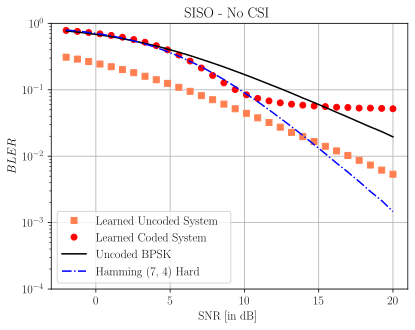

In [105]:
plt.rcParams.update({
    "text.usetex": True,
    "font.family" : 'serif',
    "font.size": 12
})
# Visualizing the results :
# Comparable BLERs :
BLER_learned_coded = [0.782804, 0.757062, 0.728338, 0.695276, 0.659079, 0.618342, 0.570953, 0.519686, 0.461912, 0.399233, 0.333961, 0.270863, 0.212819, 0.164424, 0.1269, 0.100947, 0.083949, 0.07409, 0.068043, 0.063651, 0.060774, 0.058684, 0.056981, 0.055849, 0.05462, 0.054154, 0.052975, 0.052977, 0.052481, 0.051837]
BLER_learned_uncoded = [0.309743, 0.289982, 0.266457, 0.244382, 0.222372, 0.201309, 0.180745, 0.159852, 0.14164, 0.1248, 0.109083, 0.094811, 0.081599, 0.070974, 0.060838, 0.051783, 0.044245, 0.037794, 0.032131, 0.027354, 0.022841, 0.019713, 0.016655, 0.014115, 0.012017, 0.010271, 0.008683, 0.00737, 0.006175, 0.005352]
BLER_uncoded_ortho = [0.768583, 0.739292, 0.705981, 0.669923, 0.630311, 0.587876, 0.544343, 0.500471, 0.455975, 0.410657, 0.367179, 0.327169, 0.287849, 0.252541, 0.220754, 0.191105, 0.165363, 0.142107, 0.121575, 0.104422, 0.08893, 0.075213, 0.064247, 0.054353, 0.045771, 0.038804, 0.032647, 0.027541, 0.023478, 0.019544]
BLER_coded_ortho_hard = [0.795571, 0.765834, 0.731717, 0.692848, 0.648438, 0.599435, 0.545317, 0.489533, 0.432764, 0.375165, 0.320971, 0.267871, 0.221556, 0.178709, 0.142342, 0.111386, 0.086019, 0.066173, 0.049922, 0.037385, 0.027819, 0.020596, 0.014932, 0.010915, 0.007867, 0.005756, 0.004155, 0.00294, 0.002141, 0.001472]
fig, axes = plt.subplots()
axes.semilogy(SNR_dB, BLER_learned_uncoded, label='Learned Uncoded System', color='coral', marker='s', ls=" ")
axes.semilogy(SNR_dB, BLER_learned_coded, label='Learned Coded System', color='red', marker="o", ls=" ")
axes.semilogy(SNR_dB, BLER_uncoded_ortho, label='Uncoded BPSK', color='black')
axes.semilogy(SNR_dB, BLER_coded_ortho_hard, label='Hamming (7, 4) Hard', color='blue', ls="-.")
axes.set_xlabel(f'SNR [in dB]')
axes.set_ylabel(r'$BLER$')
axes.set_xlim(-3, 21)
axes.set_ylim(10**-4, 10**0)
axes.set_title(f'SISO - No CSI')
axes.legend()
axes.grid()

In [106]:
# Saving the results for future reference :
# Plot(s) :
fig.savefig("plots/deepSISOnoCSI.svg", transparent=True)
# BLERs :
with open("results/deepSISOnoCSI.txt", mode='w') as file_id:
    file_id.write(f'BLER_learned_coded = {BLER_learned_coded}\n')
    file_id.write(f'BLER_learned_uncoded = {BLER_learned_uncoded}\n')
    file_id.write(f'BLER_uncoded_ortho = {BLER_uncoded_ortho}\n')
    file_id.write(f'BLER_coded_ortho_hard = {BLER_coded_ortho_hard}')